# Project: Implied Volatility vs Realized Volatility for an Africa-Exposure ETF  

---

The goal is testing whether implied volatility (IV) from options on an Africa-exposure ETF forecasts next-week realized volatility (RV), and how forecast errors vary across West Africa regimes defined by Naira (NGN) volatility.

Given my Nigerian background, AFK will be our option of focus since it has Pan-African exposure and EZA is South Africa focused. AFK and EZA are the only two ETFs that can be traded with in the America. 

In [1]:
#Before running this notebook, install the required packages by executing the following commands in a code cell:

# ---- Core finance & data libraries ----
#!pip install yfinance            # download market data
#!pip install pandas              # data handling
#!pip install numpy               # math & array operations
#!pip install matplotlib          # plotting (if you graph volatility)
#!pip install scipy               # numerical methods, e.g., Brent root-finding

# ---- Option pricing & implied volatility ----
#!pip install py_vollib           # Black–Scholes–Merton pricing + implied vol
# (if py_vollib gives compilation errors, use this instead)
#!pip install py_vollib-vectorized

# ---- Optional but recommended ----
#!pip install seaborn             # prettier charts (optional)
#!pip install plotly              # interactive graphs (optional)
#!pip install tqdm                # progress bars for loops
#!pip install requests            # for robust HTTP sessions

# ---- For fallback caching or file handling ----
#!pip install json5               # reading/writing JSON cache
#!pip install pathlib             # (usually built-in with Python ≥3.4)

**Implied Volatility (IV):**

Simplied volatility is the value of $\sigma $ that satisfies the **Black–Scholes option pricing formula** for a given market option price $ C_{\text{mkt}} $:

$$
C_{\text{mkt}} = S_0 e^{-qT} N(d_1) - K e^{-rT} N(d_2)
$$

where

$$
d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + (r - q + \tfrac{1}{2}\sigma^2)T}{\sigma \sqrt{T}},
\quad
d_2 = d_1 - \sigma \sqrt{T}
$$

and

- $C_{\text{mkt}} $ = option's market price 
- S_0 = current underlying price <!-- current market price -->
- K = strike price  <!-- fixed price (or exercised price) in option contract| for call - buy @ K & for put - sell @ K -->
- r = risk-free rate  <!-- continuously compounded annualized return of a risk-free asset -->
- q = dividend yield  <!-- ratio of a company's annual dividend payment to its stock price, which can influence the value of call & put options -->
- T = time to expiration (in years)  <!-- time remaining until the option’s expiration date, can be called "theta decay" -->
- N =  cumulative normal distribution <!-- probability that a standard normally distributed random variable is less than or equal to a given number of standard deviations from the mean -->

<!-- Note: The strike price is the fixed amount you will pay (or receive) in the future, while the present value is how much that future payment (and the option’s overall payoff) is worth today, after adjusting for time and interest.  -->

The **implied volatility** $\sigma_{\text{imp}}$ is found by *inverting* this equation — i.e., solving for $\sigma$ such that the model price equals the observed market price. Since $N(d_{1})$ and $N(d_{2})$ are nonlinear cumulative normal functions, there’s no analytical way to isolate σ symbolically.

This means we cannot just “move terms around” like in normal algebra.

So instead, we invert the equation numerically — i.e., find the σ that makes the theoretical Black–Scholes price equal the observed market price. This is where Numerical inversion can be used.

$$f(σ)=C_{BS}​(S_0​,K,r,q,T,σ)−C_{mkt}$$

From here, find the root: 

$$f(σ_{imp}​)=0$$

Since we cannot do this analytically, a root-finding algorithm can be utilized. Our data provides IV already, but if we were to compute it ourselves, the *py_vollib* library would have been used. 

Example code would look like: 

In [2]:
from py_vollib.black_scholes_merton.implied_volatility import implied_volatility

option_price = 2.50   # market option price
S = 100.0             # spot
K = 105.0             # strike
t = 30/365            # time to expiry (years)
r = 0.05              # risk-free rate
q = 0.0               # dividend yield
flag = 'c'            # 'c' for call, 'p' for put

iv = implied_volatility(
    option_price,  # price
    S,             # spot
    K,             # strike
    t,             # <-- time first
    r,             # <-- then risk-free
    q,             # <-- then dividend
    flag           # <-- then 'c' or 'p'
)

print("Implied volatility:", iv)


Implied volatility: 0.37751241493004


**Realized Volatility (RV)** 

The **realized volatility** over a 5-day window measures how much the asset price actually fluctuated in that period.  
It is computed from daily log-returns and annualized to make it comparable with implied volatility.

#### Formula

$$
\text{RV}_{t \to t+5} = 
\sqrt{
\sum_{d=1}^{5} r_{t+d}^2 \cdot \frac{252}{5}
},
\quad 
r_{t+d} = \ln\!\left(\frac{S_{t+d}}{S_{t+d-1}}\right)
$$

Where:
- S_t = price of the underlying asset on day *t*
- r_{t+d} = daily log return
- 252 = approximate number of trading days per year
- 5 = number of days in the window (e.g., a trading week)
- $RV_{t \to t+5}$ = annualized realized volatility over the 5-day window

What is the relationship between IV and RV? 

#### Interpretation

- **Realized Volatility (RV):** reflects *actual* price fluctuations observed in historical data.  
- **Implied Volatility (IV):** reflects *expected* future volatility inferred from option prices.  

Comparing these two helps assess whether options are **over- or under-priced** relative to recent market behavior.


In [3]:
from pathlib import Path
import pandas as pd

root = Path.cwd()  # /Users/chidu/Downloads/Erdos_Africa
csv_path = root / "afk_options-overview-history-11-01-2025.csv"
print(csv_path.exists(), csv_path)  # should print: True /Users/chidu/...

df_afk = pd.read_csv(csv_path, sep=None, engine="python", parse_dates=["Date"])
print(df_afk.shape)


True /Users/chidu/Downloads/Erdos_Africa/afk_options-overview-history-11-01-2025.csv
(581, 10)


IV coverage: 100.0% | range: 0.00–90.60 (%)


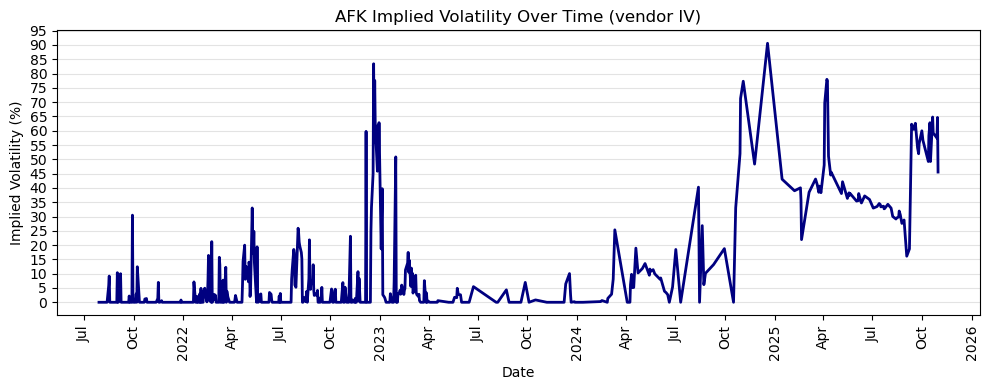

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator

dfx = df_afk.copy()

# 1) Dates
if "Date" not in dfx:
    raise KeyError("No 'Date' column found.")
dfx["Date"] = pd.to_datetime(dfx["Date"], errors="coerce")
dfx = dfx.sort_values("Date").dropna(subset=["Date"])

# 2) Find an IV column (includes your 'Imp Vol')
IV_NAMES = {
    "imp vol", "impvol", "implied vol", "impliedvol",
    "implied volatility", "iv"
}
iv_col = next((c for c in dfx.columns if c.strip().lower() in IV_NAMES), None)
if iv_col is None:
    raise KeyError(f"No IV column found. Columns: {list(dfx.columns)}")

# 3) Parse IV values from that vendor column
raw = dfx[iv_col].astype(str)
num = pd.to_numeric(raw.str.replace(r"[^0-9.\-]", "", regex=True), errors="coerce")
iv_pct = num * 100 if num.dropna().quantile(0.9) <= 1.0 else num

dfx["IV_%"] = iv_pct

covered = dfx["IV_%"].notna().mean()
print(f"IV coverage: {covered:.1%} | range: "
      f"{dfx['IV_%'].min(skipna=True):.2f}–{dfx['IV_%'].max(skipna=True):.2f} (%)")

# 4) Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dfx["Date"], dfx["IV_%"], linewidth=2, color="navy")

ax.set_title("AFK Implied Volatility Over Time (vendor IV)")
ax.set_xlabel("Date")
ax.set_ylabel("Implied Volatility (%)")
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.grid(axis="y", which="major", alpha=0.35)

locator = mdates.AutoDateLocator(minticks=12, maxticks=21)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show() 

/opt/homebrew/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


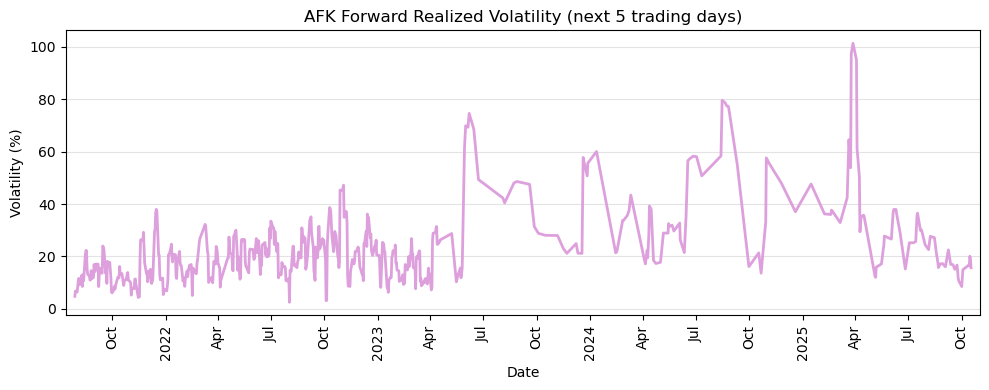

In [5]:
import numpy as np

# ---- Config ----
HORIZON = 5          # next 5 trading days
ANNUALIZE = 252
USE_LOG = True
OFFSET = 0           # start RV window t+1+OFFSET 

# ---- Pick a price column & prep ----
PRICE_COL = next((c for c in ["Last", "Close", "Adj Close", "Price"] if c in df_afk.columns), None)

df = (df_afk[["Date", PRICE_COL]]
        .rename(columns={PRICE_COL: "Price"})
        .assign(Date=lambda d: pd.to_datetime(d["Date"], errors="coerce"),
                Price=lambda d: pd.to_numeric(d["Price"], errors="coerce"))
        .dropna()
        .sort_values("Date")
        .drop_duplicates("Date", keep="last")
        .set_index("Date"))

# ---- Forward realized vol (annualized %, aligned at t) ----
r = (np.log(df["Price"]).diff() if USE_LOG else df["Price"].pct_change())
rv = r.rolling(HORIZON).std(ddof=1) * (ANNUALIZE ** 0.5) * 100
rv = rv.shift(-(HORIZON + OFFSET)).rename(f"RV_next{HORIZON}d_%").dropna()

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(rv.index, rv.values, color="plum", linewidth=2)

ax.set_title(f"AFK Forward Realized Volatility (next {HORIZON} trading days)")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility (%)")
ax.grid(axis="y", alpha=0.35)

# ~50% denser dates + vertical labels
locator = mdates.AutoDateLocator(minticks=12, maxticks=21)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

ax.margins(x=0.01, y=0.05)
plt.tight_layout()
plt.show()

/opt/homebrew/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


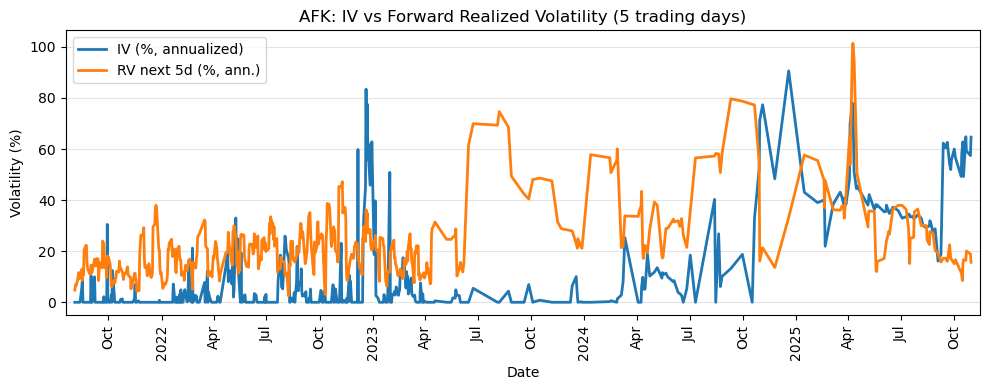

In [6]:
# --- Parameters ---
H = 5            # 5-trading-day forward horizon
ANNUALIZE = 252  # trading days per year

# IV vs forward RV (5d), simple & realistic — IV=navy, RV=plum
# --- IV (percent) ---
iv_df = df_afk.copy()
iv_df["Date"] = pd.to_datetime(iv_df["Date"], errors="coerce")
iv_df = iv_df.dropna(subset=["Date"]).sort_values("Date")

IV_NAMES = {"imp vol", "impvol", "implied vol", "impliedvol", "implied volatility", "iv"}
iv_col = next((c for c in iv_df.columns if c.strip().lower() in IV_NAMES), None)
if iv_col is None:
    raise KeyError(f"No IV column found. Columns: {list(iv_df.columns)}")

raw = iv_df[iv_col].astype(str)
num = pd.to_numeric(raw.str.replace(r"[^0-9.\-]", "", regex=True), errors="coerce")

# If values mostly 0–1, treat as decimals and convert to %
iv_pct = num * 100 if num.dropna().quantile(0.9) <= 1.0 else num
iv = pd.Series(iv_pct.values, index=iv_df["Date"], name="IV_%").dropna()

# --- Price & forward RV (aligned at t; uses t+1..t+H) ---
PRICE_COL = next((c for c in ["Last", "Close", "Adj Close", "Price"] if c in df_afk.columns), None)
if PRICE_COL is None:
    raise KeyError(f"No price column found. Columns: {list(df_afk.columns)}")

px = (
    df_afk[["Date", PRICE_COL]]
    .assign(
        Date=lambda d: pd.to_datetime(d["Date"], errors="coerce"),
        **{PRICE_COL: lambda d: pd.to_numeric(d[PRICE_COL], errors="coerce")}
    )
    .dropna()
    .sort_values("Date")
    .drop_duplicates("Date", keep="last")
    .set_index("Date")[PRICE_COL]
)

r = np.log(px).diff()  # daily log returns

# forward-realized vol over next H days, aligned at t
rv5 = r.shift(-1).rolling(H).std(ddof=1) * (ANNUALIZE ** 0.5) * 100
rv5 = rv5.rename("RV5_%").dropna()

# --- Align & plot ---
df = pd.concat([iv, rv5], axis=1).dropna().sort_index()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.index, df["IV_%"],  label="IV (%, annualized)",   linewidth=2)
ax.plot(df.index, df["RV5_%"], label="RV next 5d (%, ann.)", linewidth=2)

ax.set_title("AFK: IV vs Forward Realized Volatility (5 trading days)")
ax.set_ylabel("Volatility (%)")
ax.set_xlabel("Date")
ax.grid(axis="y", alpha=0.35)

# ~50% denser dates + vertical labels
locator = mdates.AutoDateLocator(minticks=12, maxticks=21)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

ax.margins(x=0.01, y=0.05)
ax.legend()
plt.tight_layout()
plt.show()

/opt/homebrew/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


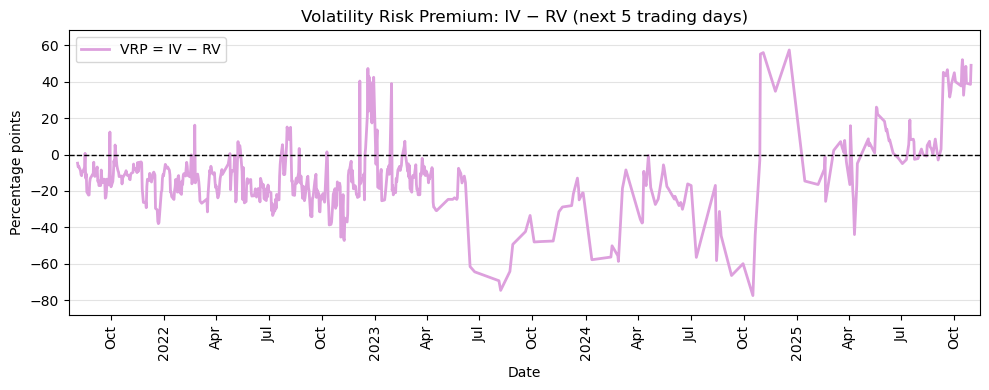

In [7]:
# Volatility Risk Premium (VRP) = IV − RV (percentage points)

H = 5           # forward window (next 5 trading days)
ANNUALIZE = 252

# --- IV (%), robust parse ---
IV_NAMES = {"imp vol", "impvol", "implied vol", "impliedvol", "implied volatility", "iv"}
iv_df = df_afk.copy()
iv_df["Date"] = pd.to_datetime(iv_df["Date"], errors="coerce")
iv_df = iv_df.dropna(subset=["Date"]).sort_values("Date")

iv_col = next((c for c in iv_df.columns if c.strip().lower() in IV_NAMES), None)

raw = iv_df[iv_col].astype(str)
num = pd.to_numeric(raw.str.replace(r"[^0-9.\-]", "", regex=True), errors="coerce")
iv_pct = num * 100 if num.dropna().quantile(0.9) <= 1.0 else num
iv = pd.Series(iv_pct.values, index=iv_df["Date"], name="IV_%").dropna()

# --- Price & forward RV (aligned at t; uses t+1..t+H) ---
PRICE_COL = next((c for c in ["Last", "Close", "Adj Close", "Price"] if c in df_afk.columns), None)

px = (df_afk[["Date", PRICE_COL]]
        .assign(Date=lambda d: pd.to_datetime(d["Date"], errors="coerce"),
                **{PRICE_COL: lambda d: pd.to_numeric(d[PRICE_COL], errors="coerce")})
        .dropna()
        .sort_values("Date")
        .drop_duplicates("Date", keep="last")
        .set_index("Date")[PRICE_COL])

r = np.log(px).diff()
rv = r.shift(-1).rolling(H).std(ddof=1) * (ANNUALIZE ** 0.5) * 100
rv = rv.rename(f"RV_next{H}d_%").dropna()

# --- VRP series (pct pts) ---
df = pd.concat([iv, rv], axis=1).dropna().sort_index()
vrp = (df["IV_%"] - df[f"RV_next{H}d_%"]).rename("VRP_pp")

# --- Plot (light purple) ---
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(vrp.index, vrp.values, linewidth=2, color="plum", label="VRP = IV − RV")
ax.axhline(0, color="black", linestyle="--", linewidth=1)

ax.set_title(f"Volatility Risk Premium: IV − RV (next {H} trading days)")
ax.set_xlabel("Date"); ax.set_ylabel("Percentage points")
ax.grid(axis="y", alpha=0.35)

locator = mdates.AutoDateLocator(minticks=12, maxticks=21)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

ax.margins(x=0.01, y=0.08)
ax.legend()
plt.tight_layout()
plt.show()

# VRP=Implied Volatility−Realized Volatility
# The difference tells you how much extra volatility the market prices in — basically, how much “fear premium” or insurance cost traders are willing to pay for protection.
# Positive (IV > RV) means options are expensive so market is overpricing risk, investors are paying a volatility premium for protection
# Negative (IV < RV) means options are cheap so market is underpricing risk, Market is underpricing risk, actual volatility exceeded expectations

#Selling volatility (e.g., selling options) profits from positive VRP on average.
#Buying volatility (long options) benefits from negative VRP periods.


In [8]:
# --- 1) IV (%) ---
IV_NAMES = {"imp vol", "impvol", "implied vol", "impliedvol", "implied volatility", "iv"}
df = df_afk.copy()
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).sort_values("Date")

iv_col = next((c for c in df.columns if c.strip().lower() in IV_NAMES), None)
if iv_col is None:
    raise KeyError(f"Couldn't find an implied-vol column in: {list(df.columns)}")

iv_num = pd.to_numeric(df[iv_col].astype(str).str.replace(r"[^0-9.\-]", "", regex=True), errors="coerce")
iv_num = iv_num * 100 if iv_num.dropna().quantile(0.9) <= 1.0 else iv_num
iv = pd.Series(iv_num.values, index=df["Date"], name="IV_%").dropna()

# --- 2) Price → forward RV (t+1..t+H, annualized %) ---
PRICE_COL = next((c for c in ["Last", "Close", "Adj Close", "Price"] if c in df_afk.columns), None)
if PRICE_COL is None:
    raise KeyError(f"No price column found in {list(df_afk.columns)}")

px = (df_afk[["Date", PRICE_COL]]
        .assign(Date=lambda d: pd.to_datetime(d["Date"], errors="coerce"),
                **{PRICE_COL: lambda d: pd.to_numeric(d[PRICE_COL], errors="coerce")})
        .dropna()
        .sort_values("Date")
        .drop_duplicates("Date", keep="last")
        .set_index("Date")[PRICE_COL])

r = np.log(px).diff()
rv = r.shift(-1).rolling(H).std(ddof=1) * (ANNUALIZE ** 0.5) * 100
rv = rv.rename("RV_next5d_%").dropna()

# --- 3) Merge (what your scatter uses) ---
df_merged = pd.concat([iv, rv], axis=1).dropna().sort_index()
print("df_merged columns:", list(df_merged.columns), "| shape:", df_merged.shape)


df_merged columns: ['IV_%', 'RV_next5d_%'] | shape: (563, 2)


/opt/homebrew/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


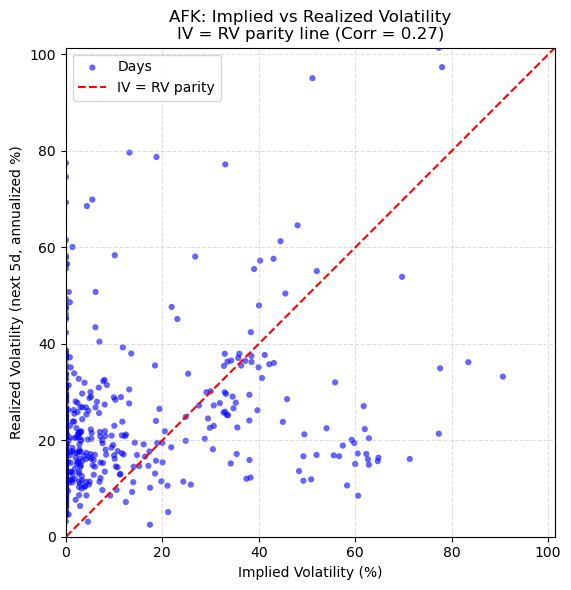

In [9]:
# Statistical relationship between forecasts (x = IV) and outcomes (y = RV).
#The red 45° parity line represents perfect foresight (IV = RV).
#The slope and clustering reveal how well IV predicts RV.

col_iv = next((c for c in ["IV_%", "IV_pct"] if c in df_merged.columns), None)
col_rv = next((c for c in ["RV5_%", "RV_next5d_%", "RV_5d_pct"] if c in df_merged.columns), None)

df_sc = df_merged[[col_iv, col_rv]].dropna().rename(columns={col_iv: "IV", col_rv: "RV"})

# Correlation
corr = df_sc["IV"].corr(df_sc["RV"])

# Scatter with 45° parity line
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_sc["IV"], df_sc["RV"], alpha=0.6, s=20, color="blue", edgecolors="none", label="Days")

lo = float(np.nanmin([df_sc["IV"].min(), df_sc["RV"].min()]))
hi = float(np.nanmax([df_sc["IV"].max(), df_sc["RV"].max()]))
ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1.5, color="red", label="IV = RV parity")

ax.set_xlim(lo, hi)
ax.set_ylim(lo, hi)
ax.set_aspect("equal", adjustable="box")

ax.set_xlabel("Implied Volatility (%)")
ax.set_ylabel("Realized Volatility (next 5d, annualized %)")
ax.set_title(f"AFK: Implied vs Realized Volatility\nIV = RV parity line (Corr = {corr:.2f})")

ax.grid(True, linestyle="--", alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()

#That red dashed line in your scatter plot is the 45-degree “parity” line — it shows where points would fall if implied volatility (IV) perfectly matched realized volatility (RV).

Now to see the value of implementing the Black-Scholes hedging strategy with the AFK market data. More specifically, lets see this strategy's value when used on Implied Volatility (IV) in the market. In other words, we will use market-implied volatility as the σ input in the Black–Scholes model to compute Greeks (especially delta) and build a hedging strategy, then study how well that hedge works. 

In [10]:
DTE = 21              # target days to expiry for the rolling ATM option
R = 0.00              # risk-free rate (annual). Keep 0.00 for simplicity
Q = 0.00              # dividend/borrow yield (annual). 0.00 is fine for a demo
ANNUALIZE = 252       # trading days/year
IV_COL_NAMES = {"imp vol","impvol","implied vol","impliedvol","implied volatility","iv"}
PRICE_CANDIDATES = ["Last", "Close", "Adj Close", "Price"]

# ----------------
# Market data prep: S_t and sigma_t from df_afk
# ----------------
df0 = df_afk.copy()
df0["Date"] = pd.to_datetime(df0["Date"], errors="coerce")
price_col = next((c for c in PRICE_CANDIDATES if c in df0.columns), None)
if price_col is None:
    raise KeyError(f"No price column found among {PRICE_CANDIDATES}. Got: {list(df0.columns)}")

iv_col = next((c for c in df0.columns if c.strip().lower() in IV_COL_NAMES), None)
if iv_col is None:
    raise KeyError(f"No implied-vol column found. Got: {list(df0.columns)}")

dfm = (df0[["Date", price_col, iv_col]]
         .rename(columns={price_col:"S", iv_col:"IVraw"})
         .assign(S=lambda d: pd.to_numeric(d["S"], errors="coerce"),
                 Date=lambda d: pd.to_datetime(d["Date"], errors="coerce"))
         .dropna(subset=["Date","S"])
         .sort_values("Date")
         .drop_duplicates("Date", keep="last")
         .set_index("Date"))

# Parse IV (% or fraction) -> decimal sigma
num = pd.to_numeric(dfm["IVraw"].astype(str).str.replace(r"[^0-9.\-]", "", regex=True), errors="coerce")
iv_pct = num * 100 if num.dropna().quantile(0.9) <= 1.0 else num    # to percent if data look like 0-1
sigma = (iv_pct / 100).rename("sigma")

mkt = pd.concat([dfm["S"], sigma], axis=1).dropna()
assert len(mkt) > DTE + 2, "Not enough days with both S and IV."

# ----------------
# Black–Scholes helpers (call)
# ----------------
def _d1_d2(S, K, T, r, q, vol):
    vsqrt = vol * np.sqrt(T)
    with np.errstate(divide="ignore", invalid="ignore"):
        d1 = (np.log(S / K) + (r - q + 0.5 * vol**2) * T) / vsqrt
    d2 = d1 - vsqrt
    return d1, d2

def bs_call_price(S, K, T, r, q, vol):
    d1, d2 = _d1_d2(S, K, T, r, q, vol)
    return S * np.exp(-q*T) * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def bs_call_delta(S, K, T, r, q, vol):
    d1, _ = _d1_d2(S, K, T, r, q, vol)
    return np.exp(-q*T) * norm.cdf(d1)

def bs_call_gamma(S, K, T, r, q, vol):
    d1, _ = _d1_d2(S, K, T, r, q, vol)
    return np.exp(-q*T) * norm.pdf(d1) / (S * vol * np.sqrt(T))

def bs_vega(S, K, T, r, q, vol):
    d1, _ = _d1_d2(S, K, T, r, q, vol)
    return S * np.exp(-q*T) * norm.pdf(d1) * np.sqrt(T)   # per 1.00 vol (not %)

In [11]:
# Rolling 21D ATM call, daily delta-hedged one-day P&L
# ----------------
# At each t: set K_t = S_t (ATM), T_t = DTE/252, T_{t+1} = (DTE-1)/252
# Use sigma_t for today and sigma_{t+1} for tomorrow pricing.
dt_years = 1.0 / ANNUALIZE
T0 = DTE / ANNUALIZE
T1 = (DTE - 1) / ANNUALIZE

S_t   = mkt["S"].iloc[:-1].values
S_tp1 = mkt["S"].iloc[1:].values
sig_t   = mkt["sigma"].iloc[:-1].values
sig_tp1 = mkt["sigma"].iloc[1:].values
K_t   = S_t.copy()  # ATM each day

# Prices & Greeks today
C_t   = bs_call_price(S_t, K_t, T0, R, Q, sig_t)
Delta = bs_call_delta(S_t, K_t, T0, R, Q, sig_t)
Gamma = bs_call_gamma(S_t, K_t, T0, R, Q, sig_t)
Vega  = bs_vega      (S_t, K_t, T0, R, Q, sig_t)

# Tomorrow's option price for the same strike K_t with 1 day less to expiry
C_tp1 = bs_call_price(S_tp1, K_t, T1, R, Q, sig_tp1)

# One-day P&L
dS = S_tp1 - S_t
unpnl = C_tp1 - C_t
hedged = unpnl - Delta * dS    # discrete delta-hedged P&L (ignoring financing)

res = (pd.DataFrame({
        "S_t": S_t, "S_tp1": S_tp1, "dS": dS,
        "sigma_t": sig_t, "sigma_tp1": sig_tp1,
        "K_t": K_t, "C_t": C_t, "C_tp1": C_tp1,
        "Delta": Delta, "Gamma": Gamma, "Vega": Vega,
        "Unhedged_dPnL": unpnl,
        "Hedged_dPnL": hedged
     }, index=mkt.index[:-1])
     .dropna())

# ----------------
# Quick diagnostics
# ----------------
def ann_factor(n):  # for daily series
    return np.sqrt(ANNUALIZE) if n > 1 else 1.0

n = len(res)
mu_unh = res["Unhedged_dPnL"].mean()
sd_unh = res["Unhedged_dPnL"].std(ddof=1)
mu_hed = res["Hedged_dPnL"].mean()
sd_hed = res["Hedged_dPnL"].std(ddof=1)

print(f"Observations: {n}")
print(f"Unhedged  mean: {mu_unh:.6f}, stdev: {sd_unh:.6f}, stdev(ann): {sd_unh*ann_factor(n):.6f}")
print(f"Hedged    mean: {mu_hed:.6f}, stdev: {sd_hed:.6f}, stdev(ann): {sd_hed*ann_factor(n):.6f}")
print(f"Variance reduction: {(1 - (sd_hed**2)/(sd_unh**2)):.1%}")


NameError: name 'norm' is not defined

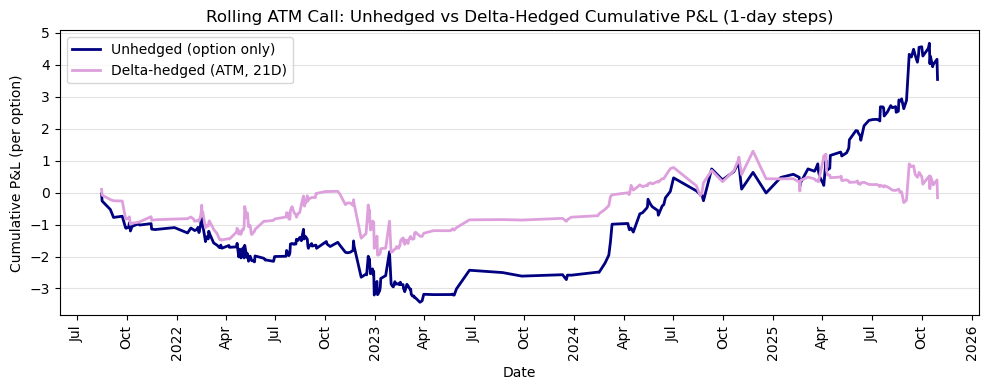

In [ ]:
# (1) Cumulative P&L: unhedged vs hedged
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(res.index, res["Unhedged_dPnL"].cumsum(), label="Unhedged (option only)", color="navy", linewidth=2)
ax.plot(res.index, res["Hedged_dPnL"].cumsum(),   label="Delta-hedged (ATM, 21D)", color="plum", linewidth=2)
ax.set_title("Rolling ATM Call: Unhedged vs Delta-Hedged Cumulative P&L (1-day steps)")
ax.set_xlabel("Date"); ax.set_ylabel("Cumulative P&L (per option)")
ax.grid(axis="y", alpha=0.35)
loc = mdates.AutoDateLocator(minticks=12, maxticks=21)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
ax.legend()
plt.tight_layout()
plt.show()


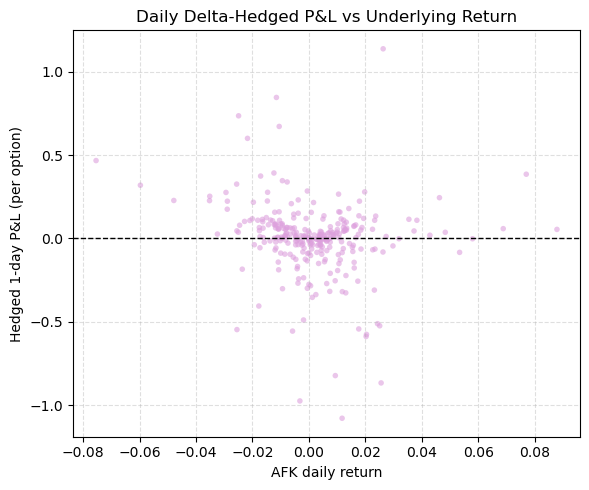

In [ ]:
# (2) Daily hedged P&L vs underlying return: should be near-zero slope if hedge works
ret = (res["S_tp1"] / res["S_t"] - 1.0).rename("S_return")  # <-- use res columns (aligned)
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(ret, res["Hedged_dPnL"], s=16, alpha=0.6, color="plum", edgecolors="none")
ax.axhline(0, color="black", linestyle="--", linewidth=1)
ax.set_title("Daily Delta-Hedged P&L vs Underlying Return")
ax.set_xlabel("AFK daily return")
ax.set_ylabel("Hedged 1-day P&L (per option)")
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()